# Modelo preditivo - preço médio de carros

- Autor: [Vagner Bessa](https://github.com/bessavagner)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from process import process_data

plt.style.use('dark_background')

In [4]:
file_path = "fipe_carros-outubro-2022.csv"
data = process_data(file_path)
data.sample(6)

,marca,modelo,combustivel,cambio,tamanho_motor,ano,preco_medio,idade
15501,Mercedes-Benz,S-500L 5.0,Gasolina,manual,5.0,2004,129672.0,19
7931,Fiat,Palio 1.0 Celebr. ECONOMY F.Flex 8V 2p,Gasolina,manual,1.0,2011,24549.0,12
9408,Ford,Verona GLX 1.8i / 1.8 4p,Álcool,manual,1.8,1995,6750.0,28
8574,Fiat,UNO SPORTING Dualogic 1.4 EVO Flex 8V 4p,Gasolina,manual,1.4,2016,46582.0,7
24365,VW - VolksWagen,Santana CLi /CL /C 1.8/2.0 /SU 2.0 2p/4p,Gasolina,manual,1.8,1997,13552.0,26
21054,Renault,Scénic Privilège Hi-Flex 1.6 16V,Gasolina,manual,1.6,2007,17657.0,16


## Seleção de dados:

- As 4 marcas com mais modelos.
- Modelos com tamanho de motor 1.0.
- Modelos com câmbio manual.
- Modelos a gasolina.

In [5]:
top4_marcas = data['marca'].value_counts()[:4]
top4_marcas

GM - Chevrolet     2365
VW - VolksWagen    2355
Fiat               2234
Ford               2013
Name: marca, dtype: int64

In [6]:
def selecionar(dados, marcas=top4_marcas.index):
    # Data selection: top 4 brands, 1.0, manual
    mask1 = dados['marca'].isin(marcas)
    selecao = dados[mask1]

    mask2 = (selecao['tamanho_motor'] == 1.0) & \
            (selecao['cambio'] == 'manual') & \
            (selecao['combustivel'] == 'Gasolina')
    selecao = selecao[mask2]

    return selecao

In [7]:
selecao = selecionar(data)

### Plot das distribuição dos preços de acordo com a idade do veículo

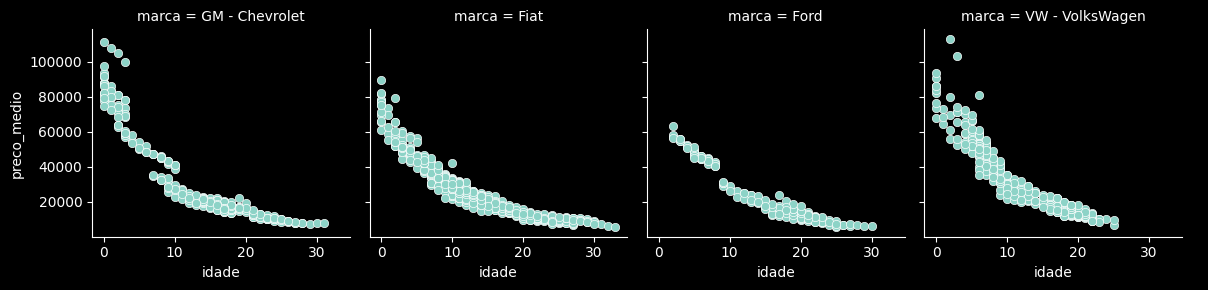

In [8]:
grid = sns.FacetGrid(selecao, col="marca")
grid.map_dataframe(sns.scatterplot, x="idade", y="preco_medio")
grid.add_legend()

## Regressão linear
Suposição: o preço médio é uma função exponencial da idade do carro: $y(x) = P_0e^{-\gamma x}$. 

Com isso, aplicamos uma transformação logarítmica para obter uma relação linear:

$$
\text{ln}(y) = \text{ln}(P_0) - \gamma x
$$

In [9]:
selecao['log_preco'] = np.log(selecao['preco_medio'])
selecao.sample(5)

,marca,modelo,combustivel,cambio,tamanho_motor,ano,preco_medio,idade,log_preco
25118,VW - VolksWagen,Fox City 1.0Mi/ 1.0Mi Total Flex 8V 3p,Gasolina,manual,1.0,2006,16868.0,17,9.733174
4164,GM - Chevrolet,Corsa Hat. Maxx 1.0/ 1.0 FlexPower 8V 5p,Gasolina,manual,1.0,2008,19443.0,15,9.875242
25832,VW - VolksWagen,Gol BLACK 1.0 Mi Total Flex 8V 4p,Gasolina,manual,1.0,2012,26277.0,11,10.176449
7456,Fiat,Siena 1.0/ EX 1.0 mpi Fire/ Fire Flex 8v,Gasolina,manual,1.0,2008,24044.0,15,10.087641
8555,Fiat,Palio Way Celebration 1.0 F. Flex 8V 5p,Gasolina,manual,1.0,2016,35923.0,7,10.489133


In [10]:
alvo = selecao['log_preco'].values
entrada = selecao[['idade']].values

In [11]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    entrada, alvo, test_size=0.2, random_state=42
)
print("Total de amostras teste:", xtest.shape[0])
print("Total de amostras de treinamento:", xtrain.shape[0])

Total de amostras teste: 222
Total de amostras de treinamento: 884


In [12]:
from IPython.display import display, Latex
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

resultado = linreg.fit(xtrain, ytrain)

Po = np.exp(resultado.intercept_)
gamma = resultado.coef_[0]

display(Latex(f"$\hat{{y}} = {Po:.2f}\exp({{{gamma:.4f}x}})$"))

<IPython.core.display.Latex object>

### Verificações do modelo:
- Escore R².
- p-value;
- Comparação de alvos e previsões:
  - ferramenta: scatterplot;
  - critério: distribuição linear com relação aproximada de $y = x$ (ou 45º no caso de uma escala 1:1).
- Distribuição dos resíduos:
  - ferramenta: plot de distribuição;
  - critério: distribuição normal centrada em zero.

In [17]:
from sklearn.feature_selection import f_regression
R2 = linreg.score(xtrain, ytrain)
pvalue = f_regression(xtrain, ytrain)[1][0]
print(f"R² = {R2}")
print(f"p-value = {pvalue}")


R² = 0.9424420725080683
p-value = 0.0


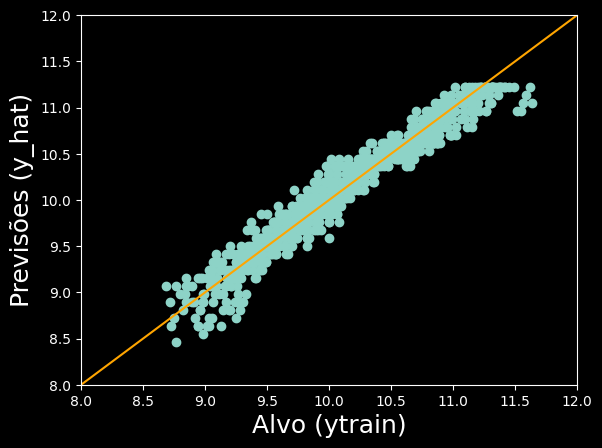

In [13]:
y_hat = linreg.predict(xtrain)

X = np.linspace(0, 12)

plt.plot(X, X, color='orange')  # reta y = x (ou 45º em uma escala 1:1)
plt.scatter(ytrain, y_hat)
plt.xlabel('Alvo (ytrain)',size=18)
plt.ylabel('Previsões (y_hat)',size=18)
plt.xlim(8,12)
plt.ylim(8,12)
plt.show()

Text(0.5, 1.0, 'Resíduos - Distribuição de probabilidade')

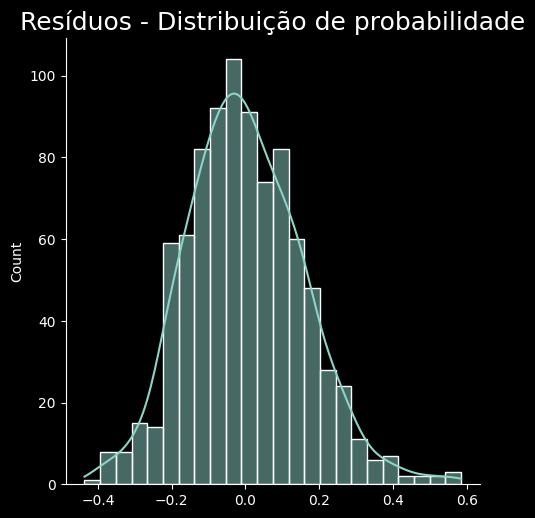

In [14]:
sns.displot(ytrain - y_hat, kde=True)

plt.title("Resíduos - Distribuição de probabilidade", size=18)

### Gráfico preço médio vs idade
Distribuição de preços por idade contra a função de previsão $y(x) = P_0e^{-\gamma x}$.

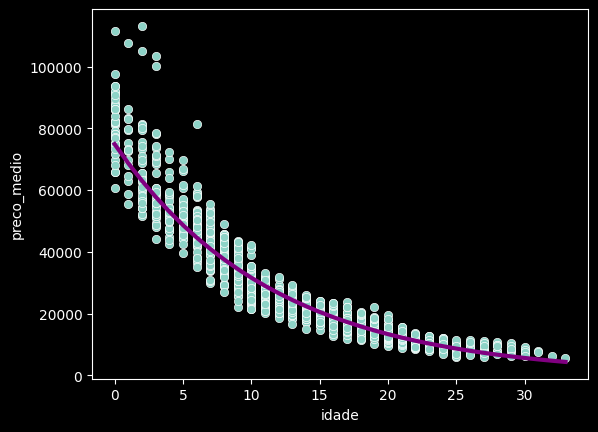

In [15]:
yfit = Po*np.exp(gamma*entrada)

ax1 = sns.lineplot(y=yfit.flatten(), x=entrada.flatten(), linewidth=3, color='purple')
ax2 = sns.scatterplot(selecao, x="idade", y="preco_medio", ax=ax1)